# Using Sentinel-1 and -2 data to build a land use classification model/ Ứng dụng ảnh viễn thám Sentinel 1 và Sentinel-2  trong phân loại hiện trạng sử dụng đất (thí điểm tại xã Thuận Hòa, huyện Châu Thành, tỉnh Sóc Trăng)

## Overview/Tổng quan
This notebook will take you through a workflow for processing Sentinel-1 and -2 data./ Phần này hướng dẫn quy trình xử lý ảnh Sentinel 1 và 2

## Required datafiles/Các dữ liệu yêu cầu
This notebook requires three files:/ Trong phần này, các dữ liệu được yêu cầu bao gồm:
- A shapefile that contains land use information/Dữ liệu điểm khảo sát thực địa: `ST_training data_updated_1130points.shp`
- A raster sentinel-1 vv file (single VV polarisation)/Dữ liệu ảnh Sentinel 1 phân cực VV định dạng raster: `vv-0922_0923-full_ST.tif`
- A raster sentinel-1 vh file (single VH polarisation) )/Dữ liệu ảnh Sentinel 1 phân cực VH định dạng raster: `vh-0922_0923-full_ST.tif`
[Sentinel-1](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/product-overview/polarimetry) can collect several different images from the same series of pulses by using its antenna to receive specific polarisations simultaneously. Sentinel-1 is a phase-preserving dual polarisation SAR system. It can transmit a signal in either horizontal (H) or vertical (V) polarisation, and then receive in both H and V polarisations./ Sentinel 1 là vệ tinh RADAR khẩu độ tổng hợp có thể thu thập các ảnh khác nhau từ một chuỗi ảnh bằng việc sử dụng ăng ten thu nhận đồng thời các phân cực (VH, VV). Sentinel 1 là ảnh SAR với phân cực kép, có thể truyền tín hiệu theo phân cực ngang (H), phân cực dọc (V), sau đó nhận tín hiệu ở cả phân cực H và V.

## Setting up your notebook/Cài đặt notebook của bạn

We will now setup your notebook so that you have all of the required python modules to query, analyse and plot the data./Chúng tôi sẽ thiết lập Notebook để người dùng có tất cả các mô-đun cần thiết cho truy vấn, phân tích và vẽ biểu đồ dữ liệu

### Import modules/Nhập các mô-đun

In [3]:
%%time
# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Common imports and settings
import os, sys
os.environ['USE_PYGEOS'] = '0'
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr

# Datacube
import datacube
from datacube.utils.rio import configure_s3_access
from datacube.utils import masking
from datacube.utils.cog import write_cog
# https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
from dea_tools.plotting import display_map, rgb
from dea_tools.datahandling import mostcommon_crs

# EASI defaults
easinotebooksrepo = '/home/jovyan/easi-notebooks'
if easinotebooksrepo not in sys.path: sys.path.append(easinotebooksrepo)
from easi_tools import EasiDefaults, xarray_object_size, notebook_utils, unset_cachingproxy
from easi_tools.load_s2l2a import load_s2l2a_with_offset

# Data tools
import numpy as np
from datetime import datetime

# Datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_masking.py
from odc.algo import xr_reproject   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_warp.py
from datacube.utils.geometry import GeoBox, box  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/geometry/_base.py

# Holoviews, Datashader and Bokeh
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
from utils import load_data_geo
import rasterio
import os
import rioxarray
# import geoviews as gv
# from holoviews.operation.datashader import rasterize
hv.extension('bokeh', logo=False)

from deafrica_tools.bandindices import calculate_indices
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import joblib

CPU times: user 7.86 s, sys: 1.43 s, total: 9.29 s
Wall time: 8.61 s


### Setting up dask/Thiết lập dask
We will now set up a dask cluster. The below code sets up a 'dask gateway' which allows processing of up to 10 worker nodes (cores) for fast parallel processing./Chúng ta sẽ thiết lập cụm dask. Đoạn code dưới đây cho phép thiết lập một “cổng dask” với việc xử lý tối đa 10 lõi chạy song song.
The below code usually takes about 3 minutes to run while dask starts up a new cluster. Once the cluser has initiliased, you can click Launch dashboard in JupyterLab to monitor the cluster acitivity./Code này mất 3 phút để chạy khi dask khởi tạo một cụm mới. Khởi chạy bảng điều khiển trong JupyterLan để theo dõi hoạt động của cụm vừa được tạo.

In [4]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
client

An existing cluster was found. Connecting to: easihub.7ea54e58628249fd9db4bf7b08f023ae
CPU times: user 23.1 ms, sys: 6.32 ms, total: 29.4 ms
Wall time: 139 ms


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.7ea54e58628249fd9db4bf7b08f023ae/status,


### Loading the datacube/Tải khối dữ liệu
Next we load the datacube object. This datacube is what we will use to read the satellite data into memory. We must also configure s3 access to the Sentinel-2 data which is available in the cloud./Datacube chính là khối dữ liệu chứa các ảnh viễn thám. Trong đó, chúng ta cần cấu hình quyền truy cập vào dữ liệu Sentinel 2 có sẵn trên đám mây.

In [5]:
# Initialise a datacube object
dc = datacube.Datacube()

# Configure s3 access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

### Defining a search query/Truy vấn dữ liệu
We now need to query the sentinel-2 cloud database on EASI. To extract data we define a query dictionary that contains search criteria such as spatial and temporal limits./ Bây giờ chúng ta cần truy vấn cơ sở dữ liệu đám mây Sentinel-2 trên EASI. Để trích xuất dữ liệu, xác định các tiêu chí, điều kiện truy vấn như giới hạn không gian (khu vực nghiên cứu), thời gian (giai đoạn nghiên cứu)

In [6]:
# Specify the start and end times 
min_date = '2022-09-01' # Thời gian bắt đầu lấy data cho quá trình train
max_date = '2023-10-01' # Thời gian kết thúc lấy data cho quá trình train
# Just do 1 month for testing
# max_date = '2022-10-01' # Thời gian kết thúc lấy data cho quá trình train

# Specify a spatail region to search using latitude/longitude cooridinates
min_longitude, max_longitude = (105.5, 106.4)
min_latitude, max_latitude = (9.2, 10.0)

# Specify the product. In this case we want to use Sentinel-2 Level-2A data
product = 's2_l2a'

# Construct the search query dictionary
query = {
    'product': product,                     # Product name
    'x': (min_longitude, max_longitude),    # "x" axis bounds
    'y': (min_latitude, max_latitude),      # "y" axis bounds
    'time': (min_date, max_date),           # Any parsable date strings
}

### Most common CRS/Hệ quy chiếu, phép chiếu phổ biến
We can select the most appropriate CRS projection using the notebook_utils helper function. This function takes into account the data product and spatial location and determines the most common CRS for that region. It generally takes 1-2 seconds to find the most common CRS./ Chúng ta có thể chọn phép chiếu CRS phù hợp nhất ứng dụng hàm trợ giúp notebook_utils. Hàm này xem xét cả về dữ liệu và vị trí không gian, xác định CRS phổ biến nhất cho khu vực quan sát. Thông thường sẽ mất 1-2 giây để tìm CRS phổ biến nhất.

In [7]:
# Most common CRS
native_crs = notebook_utils.mostcommon_crs(dc, query)
print(f'Most common native CRS: {native_crs}')

Most common native CRS: EPSG:32648


### Target xarray parameters/Các thông số xarray mục tiêu
Next we can define which target parameters we would like to load into our xarray object. In general we need to:/ Tiếp theo, chúng ta xác định tham số nào cần tải về cho đối tượng xrray. Cụ thể:
- Select a set of measurements to load/Chọn một tập hợp các kênh ảnh cần tải 
- Define an appropriate output CRS and resolution/Xác định hệ quy chiếu và độ phân giải ảnh
- Decide on how we group the data (usually we groupby input scenes on the same day to a single time layer)./Xác định các nhóm dữ liệu (thông thường các dữ liệu cùng ngày sẽ được nhóm vào cùng 1 lớp dữ liệu thời gian)
- Select a reasonable Dask chunk size (this should be adjusted depending on the spatial and resolution parameters you choose/Chọn kích thước Chun dask phù hợp (nó được điều chỉnh phụ thuộc vào thông số thời gian và không gian)

In [8]:
# Specify the spectral band measurements we want to use for a classification algorithm
measurements = ['blue', 'green', 'red', 'nir', 'scl']

load_params = {
    'measurements': measurements,                   # Selected measurement or alias names
    'output_crs': native_crs,                       # Target EPSG code
    'resolution': (-10, 10),                        # Target resolution
    'group_by': 'solar_day',                        # Scene grouping
    'dask_chunks': {'x': 2048, 'y': 2048},          # Dask chunks
}

### Loading the data/Tải dữ liệu
We are now read to load the data into our datacube object. For sentinel-2 data we can use the **load_s2l2a_with_offset** helper function so that the sentinel-2 scale and offset coefficients are applied correctly. More information on this issue is discussed here./ Chúng ta đang đọc để tải dữ liệu vào datacube của bản thân. Đối với dữ liệu Sentinel-2, chúng ta có thể sử dụng hàm trợ giúp **Load_s2l2a_with_offset** để thang đo Sentinel-2 và các hệ số bù được áp dụng chính xác. Thông tin thêm về vấn đề này được thảo luận ở đây.

In [9]:
%%time
# The replacement "dc.load()" function for this product
data = load_s2l2a_with_offset(
    dc,
    query | load_params   # Combine the two dicts that contain our search and load parameters
)

# This line prints the total size of the dataset hat was loaded
notebook_utils.heading(notebook_utils.xarray_object_size(data))

display(data)

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

CPU times: user 1.45 s, sys: 3.7 ms, total: 1.46 s
Wall time: 1.54 s


### Masking



In [10]:
# # Get the scale factor and offset from the measurement metadata
# measurement_info = dc.list_measurements().loc[query1['product']].loc[query1['measurements']]  # Pandas dataframe
# display(measurement_info)

# The "SCL" band contains quality flags and information. The details can also be found in the metadata.
flag_name = 'scl'
flag_desc = masking.describe_variable_flags(data[flag_name])  # Pandas dataframe
display(flag_desc)
display(flag_desc.loc['qa'].values[1])

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

In [11]:
# Create a "data quality" Mask layer
flags_def = flag_desc.loc['qa'].values[1]
good_pixel_flags = [flags_def[str(i)] for i in [2, 4, 5, 6]]  # To pass strings to enum_to_bool()

# enum_to_bool calculates the pixel-wise "or" of each set of pixels given by good_pixel_flags
# 1 = good data
# 0 = "bad" data

good_pixel_mask = enum_to_bool(data[flag_name], good_pixel_flags)  # -> DataArray
# display(good_pixel_mask)  # Type: bool

In [12]:
data_layer_names = [x for x in data.data_vars if x != 'scl']

In [13]:
data_layer_names

['blue', 'green', 'red', 'nir']

In [14]:
from dask.distributed import wait, progress


rs = []
for layer_name in data_layer_names:
    # Apply valid mask (calculated above) and good pixel mask
    # layer = data[[layer_name]].where(valid_mask[layer_name] & good_pixel_mask)
    layer = data[[layer_name]].where(good_pixel_mask)
    rs.append(layer)
    
# Calculate intermediate result
result = xr.merge(rs).persist()

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 9.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [16]:
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
average_ndvi = ndvi.resample(time='1M').mean().persist()  ## tính mean cho từng tháng -> time = 12

In [17]:
# This takes 48.8s
progress(average_ndvi)

VBox()

In [18]:
%%time
average_ndvi = average_ndvi.compute()

CPU times: user 4.91 s, sys: 2.92 s, total: 7.82 s
Wall time: 12.8 s


CPU times: user 557 ms, sys: 82.7 ms, total: 640 ms
Wall time: 636 ms


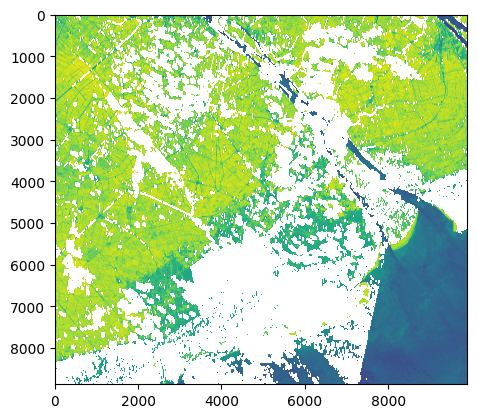

In [19]:
%%time
plt.imshow(average_ndvi.isel(time=5))

In [20]:
%%time
filled_ds = average_ndvi.bfill(dim='time')
filled_ds = filled_ds.ffill(dim='time')

CPU times: user 2.86 s, sys: 1.27 s, total: 4.13 s
Wall time: 4.19 s


CPU times: user 520 ms, sys: 83.6 ms, total: 604 ms
Wall time: 601 ms


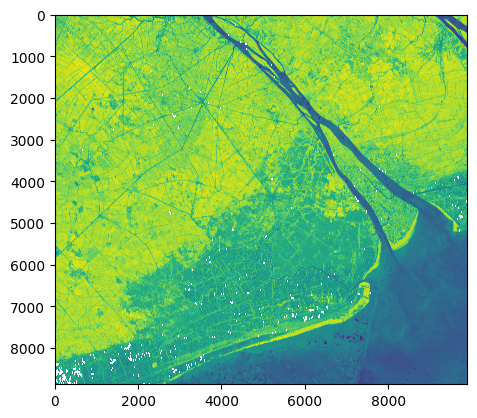

In [43]:
%%time
plt.imshow(filled_ds.isel(time=5))

In [22]:
train_path = "train/ST_training data_updated_1130points.shp"  # đường dẫn shp file train
train = load_data_geo(train_path)
train.head()

,No,X,Y,LU2022,Hientrang,HT_code,geometry
0,1.0,603860.819,1081162.862,Pomelo,CLN,5,POINT (603860.819 1081162.862)
1,2.0,601306.410,1082782.940,Pomelo,CLN,5,POINT (601306.410 1082782.940)
2,3.0,601084.510,1081351.870,Pomelo,CLN,5,POINT (601084.510 1081351.870)
3,4.0,602193.760,1079205.220,Pomelo,CLN,5,POINT (602193.760 1079205.220)
4,5.0,602459.000,1080946.000,Pomelo,CLN,5,POINT (602459.000 1080946.000)


## Downloading Sentinel-1 data/Tải ảnh Sentinel 1
The sentinel-1 data files are available via an s3 bucket. To download the files locally we will use the aws client. First, check the files are available on the s3 bucket:/ Các dữ liệu ảnh Sentinel-1 có sẵn thông qua S3 (dịch vụ lưu trữ và truy xuất của Amazon). Để tải xuống các tệp cục bộ, chúng tôi sẽ sử dụng ứng dụng khách của aws. Trước tiên, kiểm tra các tệp có sẵn trên s3:

In [ ]:
%%time
import os
if not os.path.exists("vh-0922_0923-full_ST.tif"):
    !aws s3 cp s3://easi-asia-dc-data/staging/ctu/sentinel-1/vh-0922_0923-full_ST.tif vh-0922_0923-full_ST.tif
    !aws s3 cp s3://easi-asia-dc-data/staging/ctu/sentinel-1/vv-0922_0923-full_ST.tif vv-0922_0923-full_ST.tif

download: s3://easi-asia-dc-data/staging/ctu/sentinel-1/vh-0922_0923-full_ST.tif to ./vh-0922_0923-full_ST.tif


### Load Sentinel-1 data/ Tải dữ liệu Senttinel từ S3

In [ ]:
vvpath = 'vv-0922_0923-full_ST.tif'
vhpath = 'vh-0922_0923-full_ST.tif'

dsvv = rioxarray.open_rasterio(vvpath)
dsvh = rioxarray.open_rasterio(vhpath)

### Label the training data/ Thống nhất nhãn dữ liệu thực địa

In [35]:
%%time

loaded_datasets = {}
for idx, point in train.iterrows():
    key = f"point_{idx + 1}"
    try:
        ndvi_data = filled_ds.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
        vh_data = dsvh.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
        vv_data = dsvv.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
        loaded_datasets[key] = {
            "data": np.concatenate((ndvi_data, vh_data, vv_data)),
            "label": point.HT_code
                               }
    except Exception as e:
        # loaded_datasets[key] = None
        print(e)

CPU times: user 3 s, sys: 633 ms, total: 3.64 s
Wall time: 35.6 s


In [36]:
label_mapping = {
    "Lua tom": "0",
    "Lua": "1",
    "CHN": "2",
    "CLN": "3",
    "TS": "4",
    "Song": "5",
    "Dat xay dung": "6",
    "Rung": "7"
}
label_encoder = LabelEncoder()

# Fit and transform the labels
labels = train.Hientrang.values
numeric_labels = label_encoder.fit_transform([label_mapping[label] for label in labels])

In [37]:
X = []
x_new = []
lb_new = []
for k, v in loaded_datasets.items():
    X.append(v)
for i in range(len(X)):
    if X[i] is not None:
        x_new.append(X[i]["data"])
        lb_new.append(numeric_labels[i])

### Split training data / Chia tập dữ liệu huấn luyện

In [38]:
X_train, X_temp, y_train, y_temp= train_test_split(x_new, lb_new, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Model training pipeline/ huấn luyện mô hình và đánh giá trên tập validate

In [39]:
%%time
# Tạo RandomForestClassifier mặc định để sử dụng làm mô hình ban đầu trong pipeline
base_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Tạo pipeline
pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', base_model),
])
# Thiết lập các tham số bạn muốn tối ưu hóa
param_grid = {
    'classifier__n_estimators': [100, 300, 500, 700, 1000],
    'classifier__max_depth': [6, 8, 10, 15, 20],
    'classifier__criterion': ['gini', 'entropy'],
}

# Sử dụng GridSearchCV để tìm bộ tham số tốt nhất
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# In ra bộ tham số tốt nhất
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_val)

# Đánh giá kết quả
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {round(accuracy, 2)*100} %")

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__n_estimators': 1000}
Accuracy: 85.0 %
CPU times: user 9.61 s, sys: 1.07 s, total: 10.7 s
Wall time: 1min 15s


### Accuracy on the test data/ Độ chính xác trên tập dữ liệu kiểm tra

In [40]:
## check accuracy score

y_pred_test = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy for test data {round(test_accuracy, 2)*100} %")

Accuracy for test data 88.0 %


### Save train model/ Lưu trữ mô hình huấn luyện

In [41]:
dir_save_model = "model_train"
if not os.path.exists(dir_save_model):
    os.mkdir(dir_save_model)
joblib.dump(grid_search, os.path.join(dir_save_model, "model.joblib"))

['model_train/model.joblib']

In [ ]:
client.close()
cluster.close()